# Toronto Restaurant Locations Recommendation for Startup

## Problem Statment:

## Sometimes when you would like to start a restaurant in Toronto, you have no clue where would be best locations that maximizes your potential profits and exposure.

## This project aims to solve for people who want to start up a new restaurant bussiness but worried about location picking as it provides insights for them which neighborhoods are the best candidates

---

## Stage 1: Data Collection & Preprocessing

### Web Scraping from Wikipedia

### I used requests to get the html file form the wikipedia page and then tried to find any table contained in that html

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import plotly.express as px

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
wiki_page = requests.get(url)
soup = BeautifulSoup(wiki_page.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))[0]
df

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


### Drop all `Postal Code` that were `Not assigned`

In [3]:
df_drop = df[df.Borough != 'Not assigned']
df_drop

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [4]:
df_drop.shape

(103, 3)

### Assign Latitudes and Longitudes

In [5]:
ll = pd.read_csv('Geospatial_Coordinates.csv')
ll.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
df_combine = df_drop.merge(ll,on='Postal Code')
df_combine.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Display neighborhood on map with blue marker

In [5]:
import folium
latitude = 43.651070
longitude = -79.347015
toronto_map = folium.Map(location=[latitude,longitude],zoom_start=11)

In [8]:
for lat, lng, borough, neighborhood in zip(df_combine['Latitude'], df_combine['Longitude'], df_combine['Borough'], df_combine['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)
    
toronto_map

### Get nearby venues for each neighborhood (limit to 10 venues per area in the return list)

In [3]:
client_id = "WGENET1SWCZBUQYDFZDF5DGW5AIIE1THJCXUCQ1DW4PTHJNH"
client_secret = "CHCVAO54RWBGKU0IXZGZMVZCEG4DBCAPLOGNEWQNNW3V2MQJ"
version = "20180605"

In [8]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            latitude, 
            longitude, 
            'Restaurant',
            500, 
            10)
            
# make the GET request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed170820cc1fd001b7cb6b9'},
 'response': {'warning': {'text': 'There aren\'t a lot of results for "Restaurant." Try something more general, reset your filters, or expand the search area.'},
  'headerLocation': 'Downtown Toronto',
  'headerFullLocation': 'Downtown Toronto, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'restaurant',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.6555700045, 'lng': -79.34080732988114},
   'sw': {'lat': 43.646569995499995, 'lng': -79.35322267011885}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb0eb64f964a520206a3ce3',
       'name': 'Bar Rocket',
       'location': {'address': '225 Commissioners St.',
        'lat': 43.64918,
        'lng': -79.342841,
        'la

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            'Restaurant',
            radius, 
            10)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
venues = getNearbyVenues(names=df_combine['Neighborhood'],latitudes=df_combine.Latitude,longitudes=df_combine.Longitude)

### Venue list overview

In [13]:
venues.shape

(549, 7)

- In total `428` datapoints returned

In [14]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Bella Vita Catering & Private Chef Service,43.756651,-79.331524,BBQ Joint
2,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
3,Victoria Village,43.725882,-79.315572,The Frig,43.727051,-79.317418,French Restaurant
4,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place


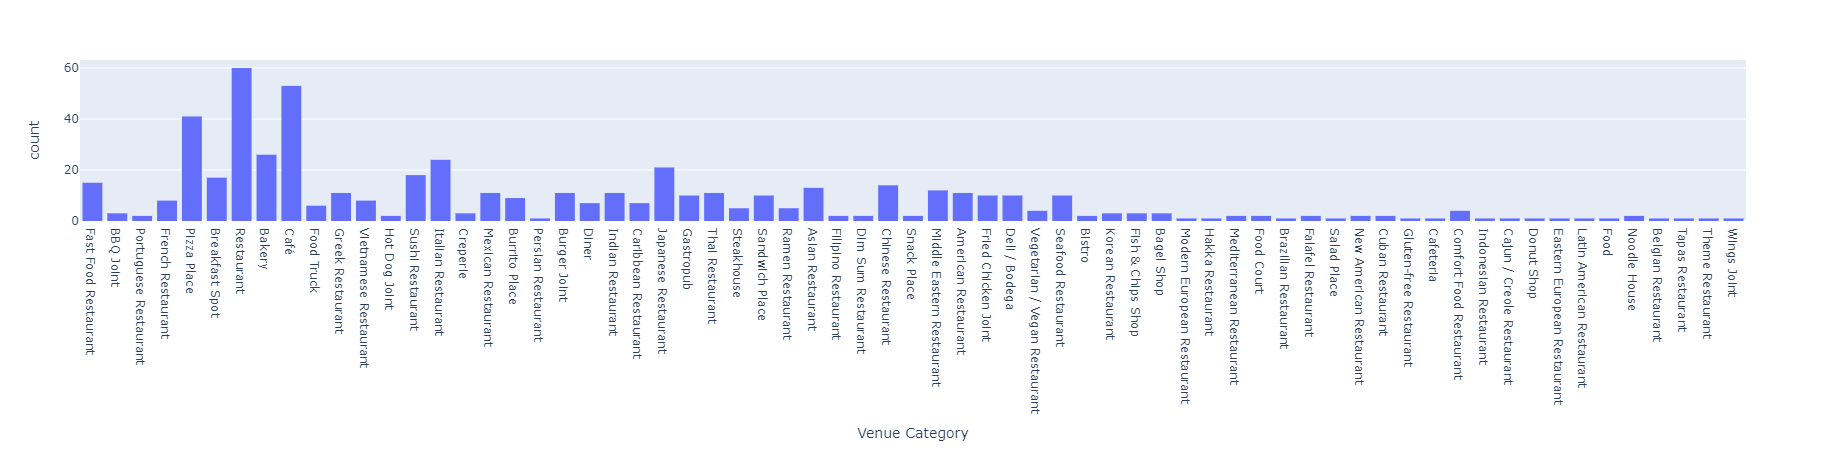

In [20]:
px.histogram(data_frame=venues,x='Venue Category')

### How many unique venue categories were in the dataset?

In [ ]:
venues['Venue Category'].nunique()

In [ ]:
venues['Venue Category'].value_counts()

- `150` unique venue categories
- `Coffee Shop` was appeared to be the most frequent venue category

### Most common venues for each neighborhood?

In [ ]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = venues['Neighborhood']

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

### Running k-means algorithm to cluster neighborhoods

In [ ]:
from sklearn.cluster import KMeans
k = 5
toronto_cluster = toronto_grouped.drop('Neighborhood',axis=1)

model = KMeans(n_clusters=k,random_state=0)
model.fit(toronto_cluster)
model.labels_[0:10]

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', model.labels_)

toronto_merged = df_combine
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),on='Neighborhood')
toronto_merged

In [ ]:
toronto_merged.dropna(subset=['Cluster Labels'],inplace=True)

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
HTML(map_clusters._repr_html_())

### Examine each cluster

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

- Cluster 0 grouped neighborhoods with common venues like `Park`,`Convenience Store`

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

- Cluster 1 grouped neighborhoods with common venues like `Pizza Place`

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

- Cluster 2 grouped neighborhoods with common venues like `Donut Shop`,`Drugstore`,`Dog Run`

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

- Cluster 3 grouped neighborhoods with common venues like `Gym`,`Cafe`,`Restaurant`

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4]

- Cluster 4 grouped neighborhoods with common venues like `Coffee Shop`